# Notebook to reproduce outputs from La Cecilia 2023

This is a notebook to reproduce outputs from  [La Cecilia and Camporese (2022)](https://onlinelibrary.wiley.com/doi/10.1002/hyp.14768) 

```{important}
# Cite this work
We believe in a community-driven approach of open-source tools that are
composable and extensible. If you use this notebook cite the work as:
> La Cecilia, D., and M. Camporese. 2022. Resolving streamflow diel fluctuations in a small agricultural catchment with an integrated surface‐subsurface hydrological model. Hydrological Processes 36(12). doi: 10.1002/hyp.14768.
```

The notebooks describes: 

1. **Preprocessing step**: how to build a mesh with different vegetation land cover and a soil including tile drains.
   - Changing atmospheric boundary conditions **Atmbc parameters**
   - Changing **Feddes parameters**
   - Changing **Soil parameters**

2. **Simulation** (very long not recommanded to execute): solve the surface-subsurface flow during a year considering different scenarios.


3. **Plot outputs**: analysis of the results
   - spatial distribution of **actual ET**
   - spatial distribution of **groundwater level depth**


```{admonition} What you should already know
In order to complete this tutorial, you should be relatively familiar with using the pyCATHY for:
- Building a mesh from a DEM (See {doc}`../content/SSHydro/index` for more information.)
- Updating soil inputs
- ...
```


```{warning}
Found a bug 🐛/ a typo ? [Email me](mailto:benjamin.mary@unipd.it)
```

We start by importing the required packages: 
- `matplotlib` in order to plot the data;
- `cathy_tools` is the main object controlling the simulation;
- `pyCATHY.importers` allows you to read CATHY input files;
- `pyCATHY.importers` allows you to read CATHY output files;
- `pyCATHY.plotters` is a set of functions in order to plot simulation outputs.

In [1]:
import os
import matplotlib.pyplot as plt
from pyCATHY import cathy_tools
from pyCATHY.importers import cathy_inputs as in_CT
from pyCATHY.importers import cathy_outputs as out_CT
from pyCATHY.plotters import cathy_plots as cplt

In [2]:
#%% Init CATHY model
# ------------------------
path2prj = '.'  # add your local path here
simu = cathy_tools.CATHY(dirName=path2prj, prj_name="LaCecilia_2022_HP")

cathy_tools

🏁 Initiate CATHY object

<module 'pyCATHY.cathy_tools' from '/home/ben/Documents/GitHub/BenjMy/pycathy_wrapper/pyCATHY/cathy_tools.py'>

## 1. Preprocessing step

Starting from DEM data (dtm_13.val) and parameters file (hap.in), the preprocessing produce a complete set of files describing physiographic features of a drainage system. Such files represent the input files for CATHY simulations.


### Building the mesh

The **DEM** should be accurate enough to account for an explicit representation of tile trains (diameter between 10 and 60 cm) 
- spatial resolution of 20x20 m necessary

```{tip}
Outside the region of interest the elevation are set to -9999
```


🔄 Update hap.in file

🔄 update dem_parameters file 

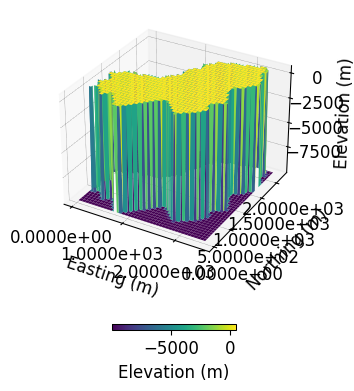

In [3]:
simu.show_input(prop="dem")

### Root map properties 

The **`veg_mag`** is a raster file that defined the position of the vegetation.

```{tip}
Outside the region of interest the elevation are set to -9999
```


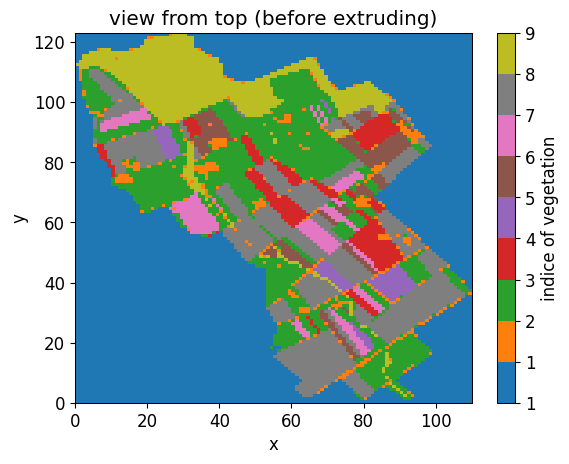

In [4]:
fig, ax = plt.subplots(1)
simu.show_input(prop="root_map", ax=ax,
               linewidth=0)


### Setting the atmospheric boundary conditions

**Scenario 1**, excludes irrigation from the reference simulation. This scenario serves primarily to assess the differences between an agricultural catchment and a natural one.

In order to update the atmospheric boundary conditions we call the following function:
```python
simu.update_atmbc()
```
Remenber that the functions arguments details can be assessed via: 

```python
help(simu.update_atmbc())
```

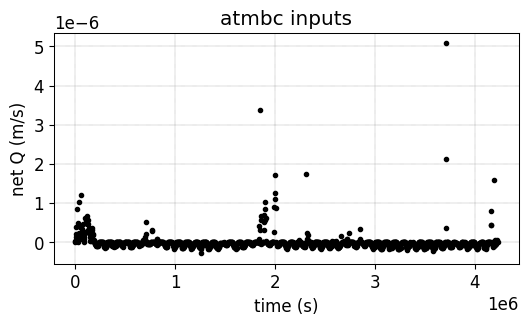

In [5]:
# first we read and plot the current atmbc file 
# --------------------------------
df_atmbc = simu.read_inputs('atmbc')
simu.show_input('atmbc')

Giving the fact that all the values are given in net Q (m/s), and that all the values are >0, here the scenario exclude the irrigation from the atmospheric boundary conditions.
Let's update the atmbc values without to with irrigation:

In [6]:
# first we read the atmbc file 
# --------------------------------
atmbc_hourlyf = os.path.join(simu.workdir,simu.project_name,'input','atmbc_hourly')
df_atmbc_hourly, HSPATM, IETO = in_CT.read_atmbc(atmbc_hourlyf)

In [7]:
help(simu.update_atmbc)
df_atmbc_hourly = df_atmbc_hourly.iloc[0:-2]

Help on method update_atmbc in module pyCATHY.cathy_tools:

update_atmbc(HSPATM=0, IETO=0, time=None, VALUE=[None, None], netValue=[], show=False, verbose=False, **kwargs) method of pyCATHY.cathy_tools.CATHY instance
    Atmospheric forcing term (atmbc - IIN6)
    
    ..note:
    
    
            1 1                HSPATM,IETO
            0.0000000e+00      time
            5.5e-06              VALUE
            12.000000e+03      time
            0.00                 VALUE
            18.000000e+03      time
            0.00                 VALUE
    
            The values are those of a 200-min rainfall event at a uniform
            intensity of 3.3·10-4 m/min, followed by 100 min of drainage.
    
    ..note:
    
            In case of simultaneous precipitation and evaporation, we impose at
            the surface the net flux, i.e., precipitation minus evaporation.
    
    
    
    
    
    Parameters
    ----------
    HSPATM : int, optional
        - =0 for spatially var

🔄 Update atmbc

🔄 update parm file 

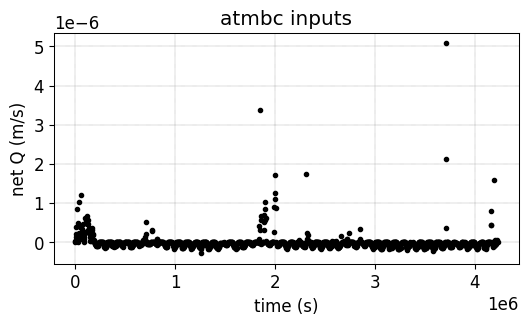

In [8]:
simu.update_atmbc(
                    HSPATM=1,
                    IETO=0,
                    time=df_atmbc_hourly['time'],
                    netValue=df_atmbc_hourly['value'],
)
simu.show_input('atmbc')

### Scenario with varying Feddes parameters

In **Scenario 2**, we additionally **excluded the effect of oxygen stress**, whereby roots could take up water even when soil moisture exceeded a threshold according to the Feddes approach

```python
simu.update_soil(FP=new_feddes_parameters)
```

We considered two test cases in **Scenario 3**. Starting from Scenario 2, we assumed a **homogeneous rooting depth** of 0.3 m in the first case and of 2.0 m in the second one.

```python
simu.update_soil(FP=new_feddes_parameters)
```


In [9]:
# first we read the current soil file 
# --------------------------------
simu.update_veg_map()
df_soil_het, df_FP = simu.read_inputs('soil')

# show Feddes parameters table
# --------------------------------
df_FP

,PCANA,PCREF,PCWLT,ZROOT,PZ,OMGC
0,0.0,-4.0,-150.0,0.001,1.0,1.0
1,0.0,-4.0,-150.0,0.300,1.0,1.0
2,0.0,-4.0,-150.0,0.400,1.0,1.0
3,0.0,-4.0,-150.0,0.500,1.0,1.0
4,0.0,-4.0,-150.0,0.800,1.0,1.0
5,0.0,-4.0,-150.0,0.900,1.0,1.0
6,0.0,-4.0,-150.0,1.000,1.0,1.0
7,0.0,-4.0,-150.0,2.000,1.0,1.0


```{note} Feddes parameters
- `PCANA`: anaerobiosis point
- `PCREF`: field capacity
- `PCWLT`: wilting point
- `ZROOT`: root depth
- `PZ`: pz is an empirical parameter
- `OMGC`: 0<OMGC<1 Compensatory mechanisms for root water uptake
```

From the table above we observe the values of the Feddes parameters for the different zones defined in the figure above. Here Zroot is varying according to the root map zone. 

### Check soil properties


| Depth (cm) | Porosity | Residual moisture content | Van Genuchten / (cm^-1) | Van Genuchten n | Specific storage coefficient (m^-1) | Saturated hydraulic conductivity (m/s) |
| --- | --- | --- | --- | --- | --- | --- |
| 0-80 | 0.43 | 0.078 | 0.036 | 1.56 | 1.00 x 10^-3 | 7.3 x 10^-5 |
| 80-140 (Tile-drain) | 0.43 | 0.078 | 0.036 | 1.56 | 1.00 x 10^-3 | 1.0 x 10^-3 | 
| 140–500 | 0.43 | 0.078 | 0.036 | 1.56 | 1.00 x 10^-3 | 7.3 x 10^-5 |

The project folder includes:
- A file with homogeneous properties
- A file with heterogeneous properties for which the hydraulic conductivity of the layer number 6 is set to $0.001 m-s^{-1}$ (>0.000073 for other layers) 



In [10]:
df_soil, df_FP = in_CT.read_soil(, dempar, MAXVEG=8)
df_soil

NameError: name 'soilfile' is not defined

In [ ]:
simu.soil

Read soil file with Tile-drain (and update existing soil file)

In [11]:
soilfile_het = os.path.join(simu.workdir,simu.project_name,'input','soil_het')
dem_parmfile = os.path.join(simu.workdir,simu.project_name,'input','dem_parameters')
dempar = in_CT.read_dem_parameters(dem_parmfile)


In [27]:
simu.update_veg_map()
df_soil, _ = simu.read_inputs('soil')
df_soil['PERMX']

,,PERMX,PERMY,PERMZ,ELSTOR,POROS,VGNCELL,VGRMCCELL,VGPSATCELL
str,zone,,,,,,,,
0,0,0.000188,0.000188,0.000188,0.00001,0.55,1.46,0.15,0.03125
1,0,0.000188,0.000188,0.000188,0.00001,0.55,1.46,0.15,0.03125
2,0,0.000188,0.000188,0.000188,0.00001,0.55,1.46,0.15,0.03125
3,0,0.000188,0.000188,0.000188,0.00001,0.55,1.46,0.15,0.03125
4,0,0.000188,0.000188,0.000188,0.00001,0.55,1.46,0.15,0.03125
5,0,0.000188,0.000188,0.000188,0.00001,0.55,1.46,0.15,0.03125
6,0,0.000188,0.000188,0.000188,0.00001,0.55,1.46,0.15,0.03125
7,0,0.000188,0.000188,0.000188,0.00001,0.55,1.46,0.15,0.03125
8,0,0.000188,0.000188,0.000188,0.00001,0.55,1.46,0.15,0.03125


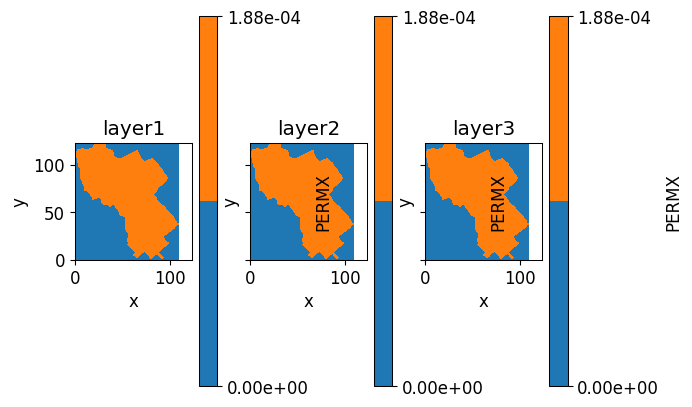

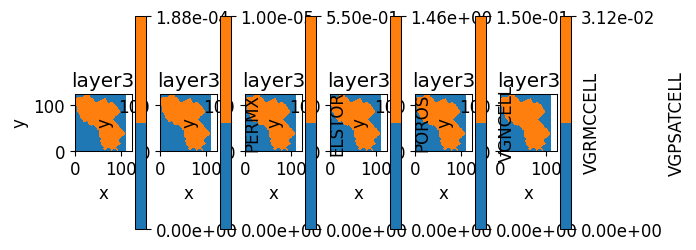

In [36]:

fig, axs = plt.subplots(1,3, sharex=True, sharey=True)
axs= axs.ravel()
for i, ax in enumerate(axs):
    simu.show_input(
                    prop="soil", 
                    yprop="PERMX", 
                    layer_nb=i,
                    ax = ax,
                    linewidth=0,
                   )
    ax.axis('square')
    ax.set_title('layer'+ str(i+1))

    
col2plot= ['PERMX', 'ELSTOR', 'POROS', 'VGNCELL', 'VGRMCCELL',
           'VGPSATCELL']

fig, axs = plt.subplots(1,len(col2plot))
for c, ax in zip(col2plot,axs):
    simu.show_input(
                    prop="soil", 
                    yprop=c, 
                    layer_nb=1,
                    ax = ax,
                    linewidth=0,
                   )
    ax.axis('square')
    ax.set_title('layer'+ str(i+1))


In [30]:
df_soil.columns


Index(['PERMX', 'PERMY', 'PERMZ', 'ELSTOR', 'POROS', 'VGNCELL', 'VGRMCCELL',
       'VGPSATCELL'],
      dtype='object')

In [26]:
#simu.update_soil(FP_map=df_FP)
#simu.soil

🔄 Update soil

homogeneous soil

{'PMIN': -5.0,
 'IPEAT': 0,
 'SCF': 1.0,
 'CBETA0': 0.4,
 'CANG': 0.225,
 'PCANA': 0    0.0
 1    0.0
 2    0.0
 3    0.0
 4    0.0
 5    0.0
 6    0.0
 7    0.0
 Name: PCANA, dtype: float64,
 'PCREF': 0   -4.0
 1   -4.0
 2   -4.0
 3   -4.0
 4   -4.0
 5   -4.0
 6   -4.0
 7   -4.0
 Name: PCREF, dtype: float64,
 'PCWLT': 0   -150.0
 1   -150.0
 2   -150.0
 3   -150.0
 4   -150.0
 5   -150.0
 6   -150.0
 7   -150.0
 Name: PCWLT, dtype: float64,
 'ZROOT': 0    0.001
 1    0.300
 2    0.400
 3    0.500
 4    0.800
 5    0.900
 6    1.000
 7    2.000
 Name: ZROOT, dtype: float64,
 'PZ': 0    1.0
 1    1.0
 2    1.0
 3    1.0
 4    1.0
 5    1.0
 6    1.0
 7    1.0
 Name: PZ, dtype: float64,
 'OMGC': 0    1.0
 1    1.0
 2    1.0
 3    1.0
 4    1.0
 5    1.0
 6    1.0
 7    1.0
 Name: OMGC, dtype: float64,
 'IVGHU': 0,
 'HUALFA': 0.02,
 'HUBETA': 2,
 'HUGAMA': 2,
 'HUPSIA': 0,
 'HUSWR': 0.333,
 'HUN': 1,
 'HUA': -5,
 'HUB': 1,
 'BCBETA': 1.2,
 'BCRMC': 0,
 'BCPSAT': -0.345}

## 2. Run simulation

Once all the inputs files are updated according to the scenario, it is good practice to run first the preprocessor in verbose = True mode to check if the preprocessing step worked. 

Then we can run the processor. As the number of times and points are large in this example it is recommanded to execute it locally.

```python
simu.run_preprocessor(verbose=True)
simu.run_processor(
                   IPRT1=2,
                   ROWMAX=247, 
                   COLMAX=221
                   )
``` 



## 3. Plot outputs

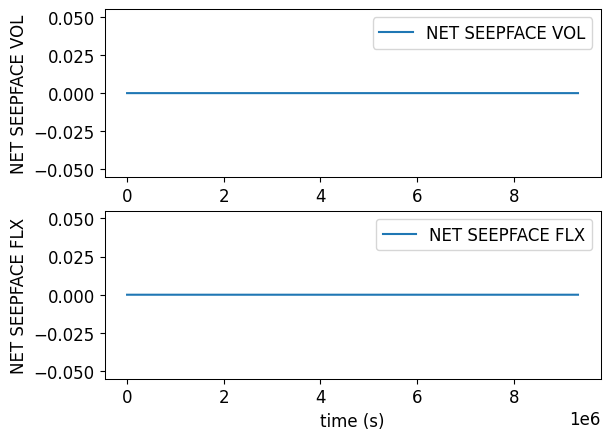

In [14]:

#%% plot NET SEEPFACE VOL and NET SEEPFACE FLX over the time t
simu.show(prop="hgsfdet")

/home/ben/Documents/GitHub/BenjMy/pycathy_wrapper/pyCATHY/importers/cathy_outputs.py:330: UserWarning: Input line 3 contained no data and will not be counted towards `max_rows=14998`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  dtcoupling = np.loadtxt(dtcoupling_file, skiprows=2, max_rows=2 + nstep)


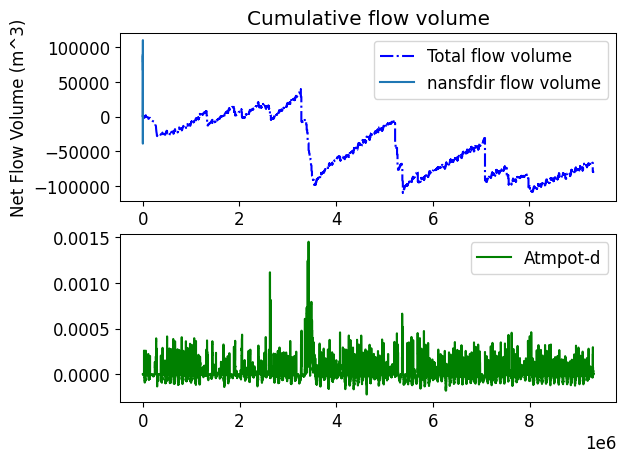

In [15]:
fig, axs = plt.subplots(2,1)

#%% plot Atmact-vf = f (time)
simu.show(prop="dtcoupling", yprop="Atmpot-d", ax=axs[0])

#%% Plot the "Total flow volume" and the "nansfdir flow volume" = f(time)
simu.show(prop="cumflowvol", ax=axs[0])




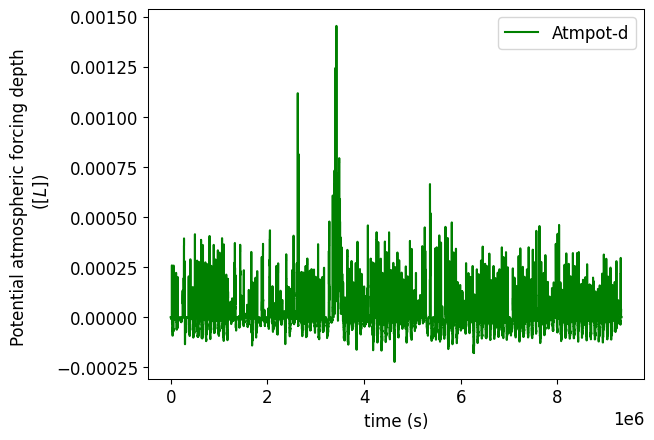

In [16]:
simu.show(prop="dtcoupling", yprop="Atmpot-d")

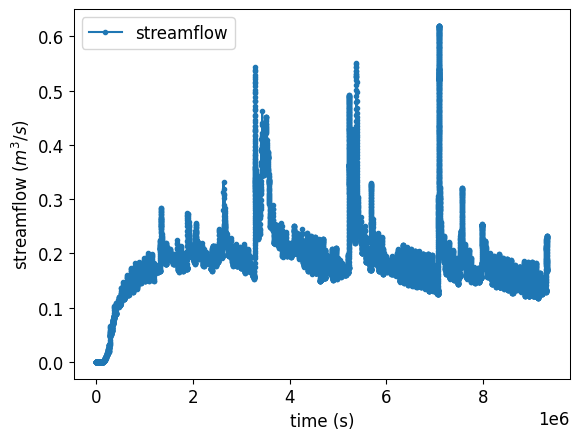

In [17]:
#%% Another interesting graph looking at the **streamflow = f(time)**
simu.show(prop="hgraph")

no file specified

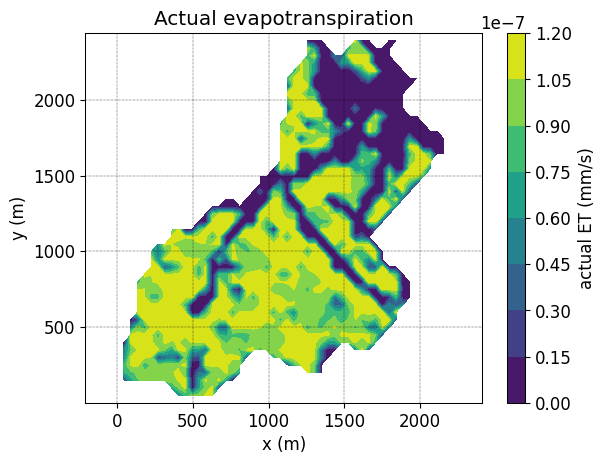

In [18]:
fig, ax = plt.subplots(1)
simu.show('spatialET',ax=ax, ti=10)

no file specified

no file specified

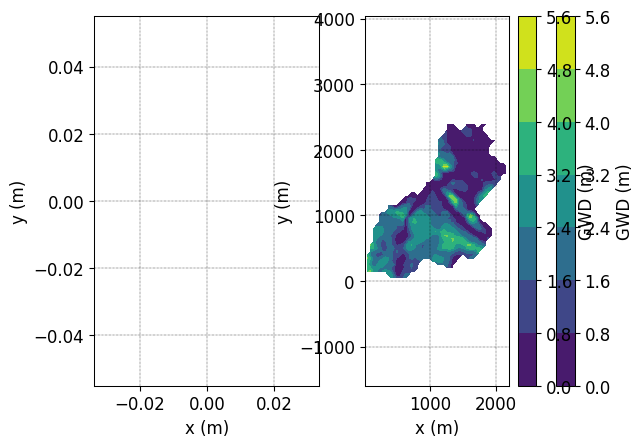

In [19]:
fig, axs = plt.subplots(1,2)
simu.show('WTD',ax=axs[0], ti=1)
simu.show('WTD',ax=axs[1], ti=10)